### _Imports_

In [29]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model  import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pylab as plt

import functions as fn # importing pre-defined functions from .py file (inside notebooks folder)

### Upload diamonds train data from csv

In [2]:
diamonds_train = pd.read_csv('../data/diamonds_train.csv')
diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1


**Remark**: For the diamonds dataset, we have conducted an exploratory data analysis (EDA) in advance. Find references [here](https://github.com/Kristinawk/EDA_Diamonds).  
  
This dataset doesn't have nulls, therefore we can proceed directly with encoding.

## 1. Features selection and engineering

### Outliers

During EDA we saw that some diamonds have ceros in size parameters x, y and z. It would be better to take these rows out for machine learning.

In [3]:
len(diamonds_train.query('x == 0 or y == 0 or z == 0'))

16

In total, there are 16 rows with this issue. Lets drop these values.

In [4]:
diamonds_train.drop(diamonds_train.query('x == 0 or y == 0 or z == 0').index, inplace=True)

Now lets see the outliers in scatter plot

In [5]:
cat_var_lst = ["city", "cut", "color", "clarity"]
num_var_lst = ([i for i in list(diamonds_train.columns) if i not in cat_var_lst])

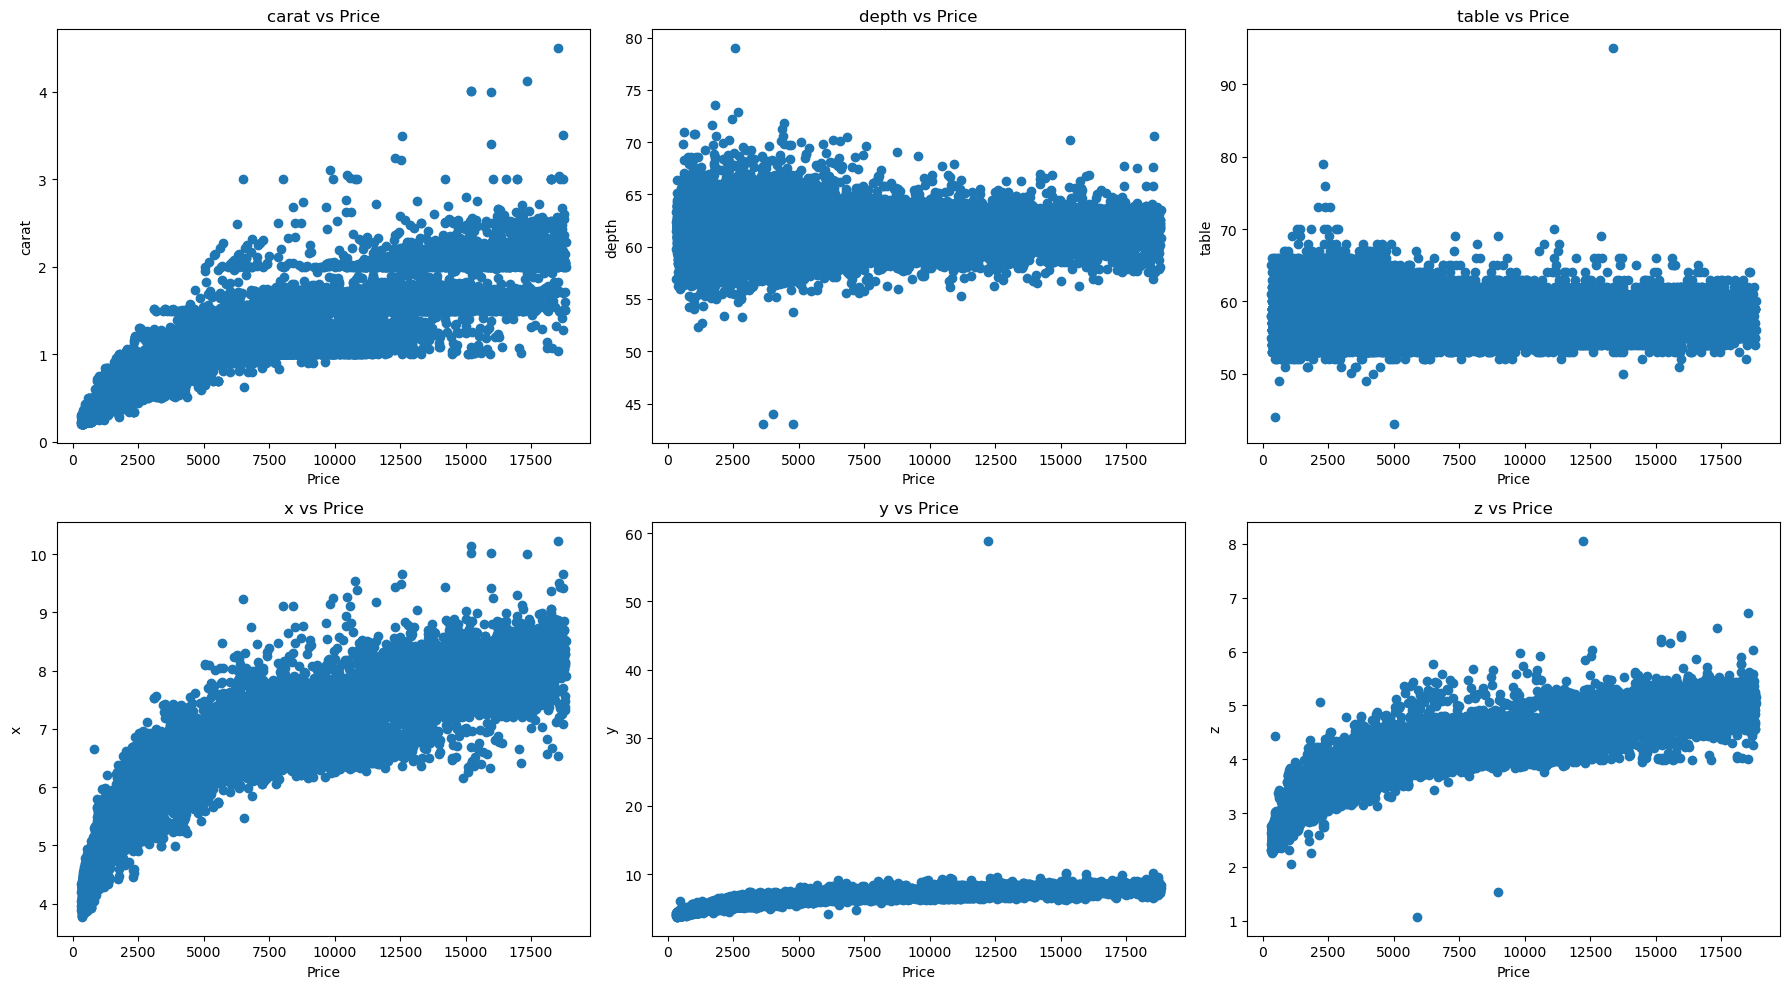

In [6]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Increase figsize for better spacing

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the features and plot on the corresponding subplot
for i, feature in enumerate(num_var_lst[1:]):  # Adjust the range to match your desired features
    ax = axes[i]  # Access the subplot
    ax.scatter(diamonds_train['price'], diamonds_train[feature])  # Scatter plot on the current axis
    ax.set_xlabel('Price')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs Price')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Lets clean the dataset

In [7]:
len(diamonds_train.query('x > 30 or y > 30 or z > 30 or z < 2 or table > 80 or table < 40 or depth > 75 or depth < 45'))

8

In [8]:
diamonds_train.drop(diamonds_train.query('x > 30 or y > 30 or z > 30 or z < 2 or table > 80 or table < 40 or depth > 75 or depth < 45').index, inplace=True)

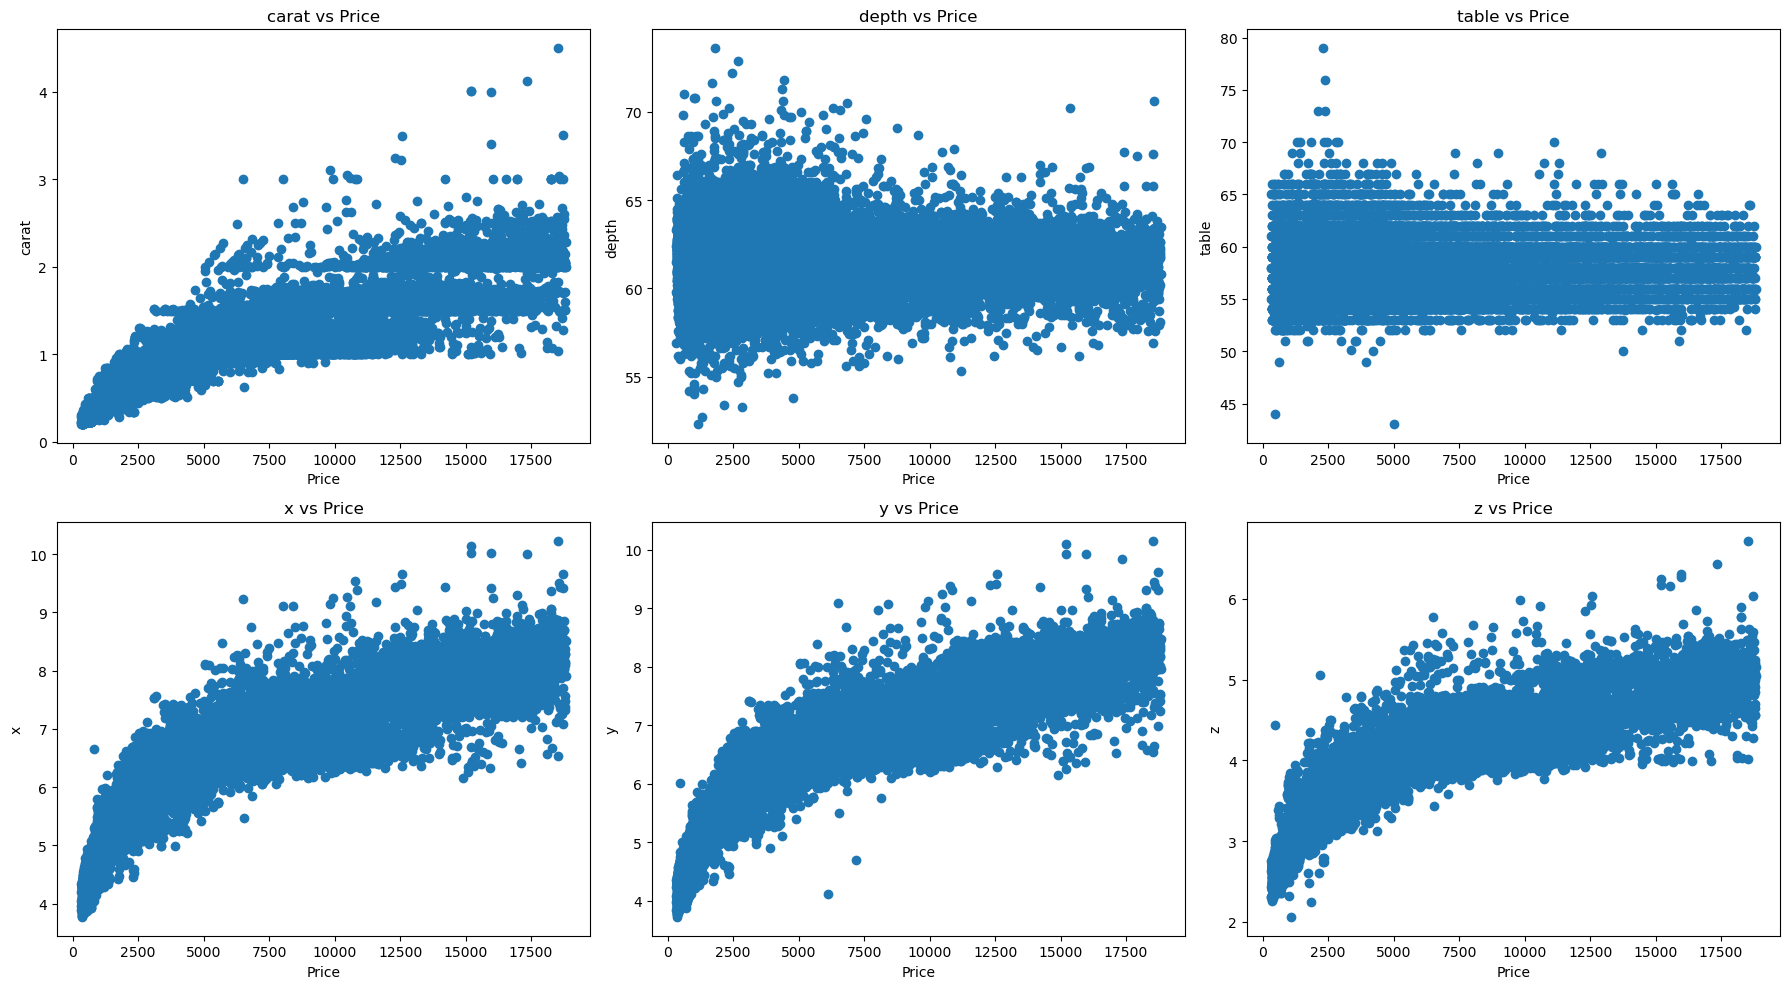

In [9]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Increase figsize for better spacing

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the features and plot on the corresponding subplot
for i, feature in enumerate(num_var_lst[1:]):  # Adjust the range to match your desired features
    ax = axes[i]  # Access the subplot
    ax.scatter(diamonds_train['price'], diamonds_train[feature])  # Scatter plot on the current axis
    ax.set_xlabel('Price')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs Price')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

The dataset seems cleaner now

## Features Engineering

Knowing that the diamonds price is mainly defined by Rapaport Diamonds Report, we will reproduce this clasification with dataset features. For this, first we need to create bins for carat and then combine them with color and clarity.

### - Carat binning

In [10]:
# K-means clustering:

kmeans = KMeans(n_clusters=10, random_state=42)
diamonds_train['carat_bin2'] = kmeans.fit_predict(diamonds_train[['carat']])

diamonds_train.head(10)

,price,carat,city,depth,table,x,y,z,cut,color,clarity,carat_bin2
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,7
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,5
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,4
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,1
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,9
5,9057,1.52,Tel Aviv,61.2,57.0,7.45,7.39,4.54,Ideal,F,SI2,3
6,3733,1.01,Amsterdam,65.2,56.0,6.23,6.19,4.05,Fair,H,VS2,9
7,8608,1.52,Kimberly,62.3,58.0,7.32,7.35,4.57,Ideal,J,VS1,3
8,557,0.31,Zurich,61.8,54.2,4.33,4.37,2.69,Ideal,H,VS1,5
9,6741,1.14,Antwerp,61.7,56.0,6.71,6.75,4.15,Ideal,G,SI1,0


In [11]:
# Get the cluster centers (mean carat value for each cluster)
cluster_centers = kmeans.cluster_centers_

# Sort the cluster centers to understand the carat ranges
sorted_centers = np.sort(cluster_centers.flatten())

# Display carat ranges corresponding to each cluster
print("Sorted cluster centers (mean carat values for each cluster):", sorted_centers)

# Create bins based on sorted cluster centers (optional)
bins = sorted_centers

Sorted cluster centers (mean carat values for each cluster): [0.30845416 0.40338621 0.53861755 0.73114882 0.97544717 1.09036488
 1.24602867 1.56188691 2.06249185 2.6159893 ]


This approach seems more reasonable, given that Rapaport report usually has 10 carat bins.

### - Combination of metrics

In [12]:
# carat + cat + clarity

diamonds_train['3C'] = diamonds_train['carat_bin2'].astype('str') + diamonds_train['color'] + diamonds_train['clarity']

diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity,carat_bin2,3C
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,7,7JVS2
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,5,5HVS2
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,4,4GVS1
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,1,1DSI1
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,9,9GSI1


In [13]:
# Define a function to apply target encoding with regularization on each row

def target_encoding(row, global_mean_price, combination_mean_price, combination_count):

    comb_key = row['3C']
    
    mean_price = combination_mean_price.get(comb_key, global_mean_price)  # Use global mean if combination not found
    count = combination_count.get(comb_key, 0)
    
    alpha = 10  # Regularization factor
    encoded_value = (count * mean_price + alpha * global_mean_price) / (count + alpha)
    
    return encoded_value

In [14]:
# Step 1: Calculate the global mean price (mean of the target)
global_mean_price = diamonds_train['price'].mean()

# Step 2: Calculate the mean price for each combination of carat_bin, color, and clarity
combination_mean_price = diamonds_train.groupby('3C')['price'].mean()

# Step 3: Calculate the count of each combination for regularization
combination_count = diamonds_train.groupby('3C')['price'].count()

# Step 6: Apply the target encoding function to each row
diamonds_train['3C_encoded'] = diamonds_train.apply(lambda row: target_encoding(
                                                                row, 
                                                                global_mean_price,
                                                                combination_mean_price,
                                                                combination_count), axis=1)

diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity,carat_bin2,3C,3C_encoded
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,7,7JVS2,5146.033968
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,5,5HVS2,689.483782
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,4,4GVS1,3031.511092
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,1,1DSI1,983.199985
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,9,9GSI1,4376.333525


In [15]:
diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40454
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       40431 non-null  int64  
 1   carat       40431 non-null  float64
 2   city        40431 non-null  object 
 3   depth       40431 non-null  float64
 4   table       40431 non-null  float64
 5   x           40431 non-null  float64
 6   y           40431 non-null  float64
 7   z           40431 non-null  float64
 8   cut         40431 non-null  object 
 9   color       40431 non-null  object 
 10  clarity     40431 non-null  object 
 11  carat_bin2  40431 non-null  int32  
 12  3C          40431 non-null  object 
 13  3C_encoded  40431 non-null  float64
dtypes: float64(7), int32(1), int64(1), object(5)
memory usage: 4.5+ MB


In [16]:
# Cut as Price Multiplier:

diamonds_train['cut'].value_counts()


cut
Ideal        16215
Premium      10250
Very Good     9095
Good          3659
Fair          1212
Name: count, dtype: int64

In [17]:
price_mult = {'Fair':1, 'Good':1.1, 'Very Good':1.2, 'Premium':1.3, 'Ideal':1.4}
diamonds_train['cut'] = diamonds_train['cut'].map(price_mult)

diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity,carat_bin2,3C,3C_encoded
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,1.3,J,VS2,7,7JVS2,5146.033968
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,1.2,H,VS2,5,5HVS2,689.483782
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,1.0,G,VS1,4,4GVS1,3031.511092
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,1.1,D,SI1,1,1DSI1,983.199985
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,1.4,G,SI1,9,9GSI1,4376.333525


In [19]:
baseline_train = diamonds_train.drop(['city', 'color', 'clarity', '3C'], axis = 1)

baseline_train.head()

,price,carat,depth,table,x,y,z,cut,carat_bin2,3C_encoded
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,1.3,7,5146.033968
1,505,0.32,63.0,57.0,4.35,4.38,2.75,1.2,5,689.483782
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,1.0,4,3031.511092
3,738,0.41,63.8,56.0,4.68,4.72,3.00,1.1,1,983.199985
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,1.4,9,4376.333525


### Correlation

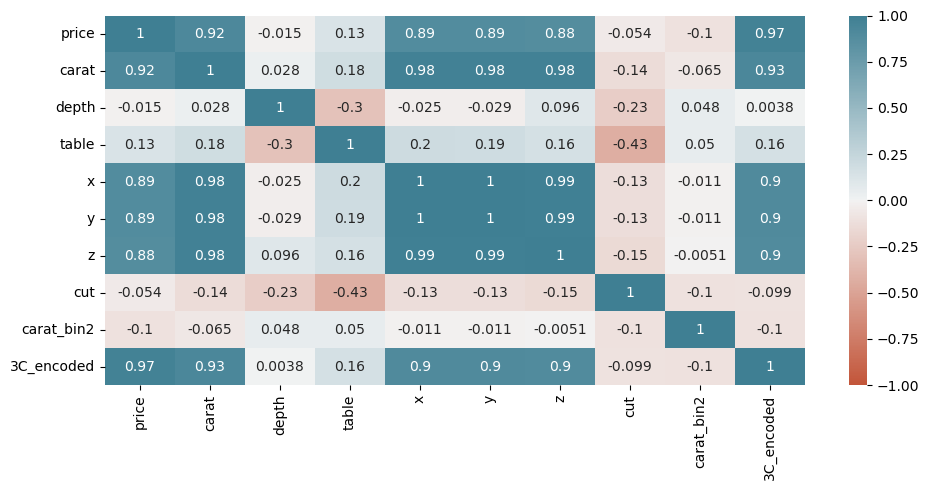

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(baseline_train.corr(),
                 vmin=-1,
                 vmax=1,
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax,
                 annot=True)
plt.tight_layout()

Lets take out metrics highly correlated

In [23]:
baseline_train = baseline_train.drop(['x', 'y', 'z'], axis = 1)

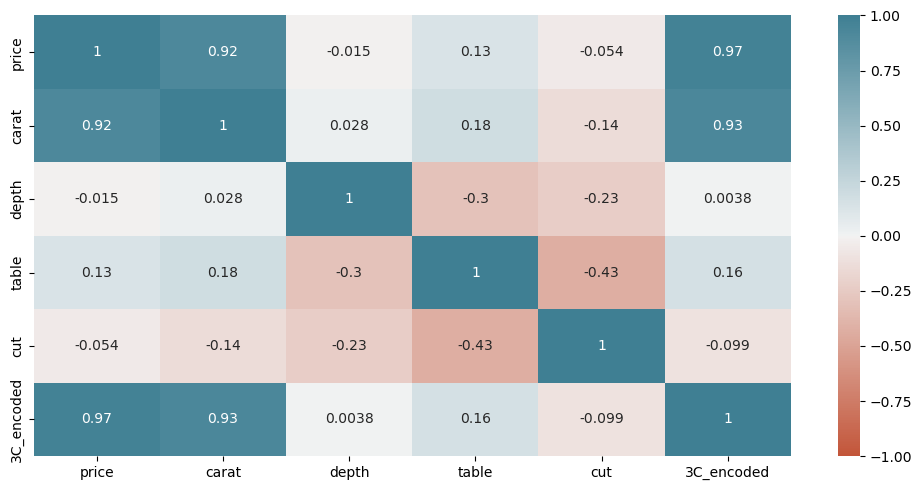

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(baseline_train.corr(),
                 vmin=-1,
                 vmax=1,
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax,
                 annot=True)
plt.tight_layout()

### Save pre-processing to csv

In [25]:
#baseline_train.to_csv('../data/baseline_train.csv', index=False)

## 3. Model selection

In [26]:
y0 = baseline_train['price'].astype('float64').to_numpy()
X0 = baseline_train[[col for col in baseline_train.columns if col != 'price']].to_numpy()

In [27]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.2, random_state = 42)
#print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
#print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

## 3. ExtraTreeRegressor

In [38]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X0)

In [39]:
scaled_data_train.shape

(40431, 5)

In [40]:
X1_train, X1_test, y1_train, y1_test = train_test_split(scaled_data_train, y0, test_size = 0.2, random_state = 42)

In [41]:
model_extratrees = ExtraTreesRegressor()

fn.cross_val(model_extratrees, scaled_data_train, y0)

Cross val. scores: [-594.69477287 -603.2604232  -606.72998575 -619.2374731  -613.11485223] 

Mean of scores: 607.4075014325329 



**CONCLUSION**: Stacking Regressor provides the best metrics: RMSE 606 in test dataset and 603 in Kaggle.

### Fit Model

In [43]:
model_extratrees.fit(X1_train, y1_train)
y1_pred = model_extratrees.predict(X1_test)

### Visual check

In [44]:
check = pd.DataFrame({'Ground truth': y1_test, 'Predictions': y1_pred, 'Diff': y1_test - y1_pred})
check

,Ground truth,Predictions,Diff
0,2217.0,2076.935,140.065
1,1798.0,2111.210,-313.210
2,13445.0,17057.850,-3612.850
3,8044.0,7900.000,144.000
4,810.0,631.000,179.000
...,...,...,...
8082,1130.0,845.705,284.295
8083,6776.0,6654.000,122.000
8084,788.0,665.750,122.250
8085,2283.0,2505.600,-222.600


In [45]:
check.reset_index(inplace=True)

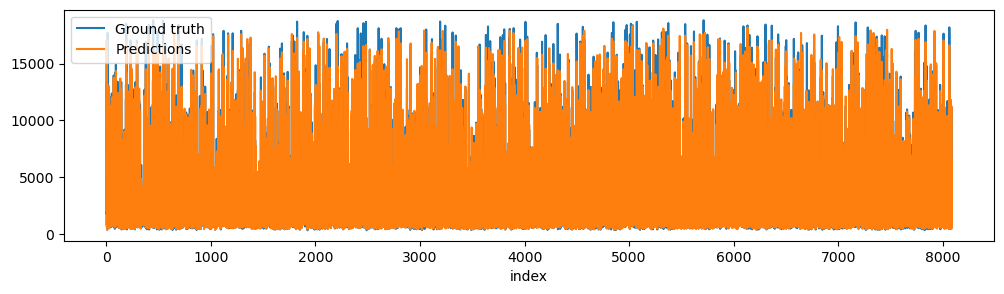

In [46]:
check.plot(x='index', y=['Ground truth', 'Predictions'], kind='line', figsize=(12, 3));

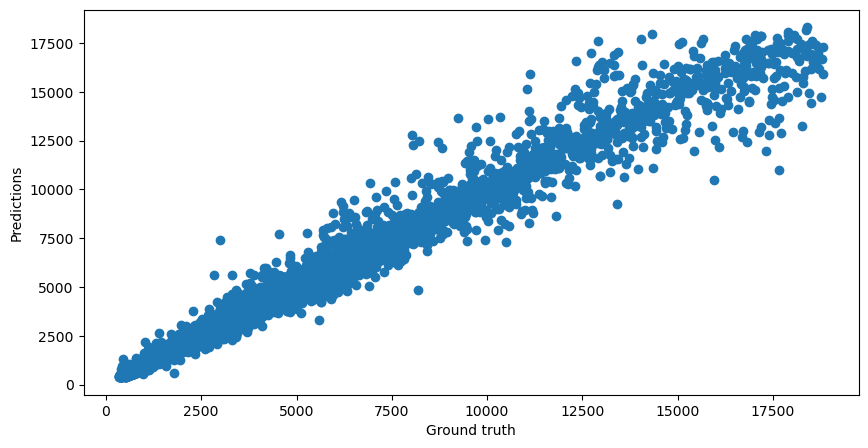

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.scatter(y1_test, y1_pred)
ax.set_xlabel('Ground truth')
ax.set_ylabel('Predictions')
#ax.set_title('')
plt.show()

# 4. Predictions

### Upload diamonds test data from csv

In [48]:
diamonds_test = pd.read_csv('../data/diamonds_test.csv')
#diamonds_test.head()

### Transformations

In [49]:
# K-means clustering:

kmeans2 = KMeans(n_clusters=10, random_state=42)
diamonds_test['carat_bin2'] = kmeans2.fit_predict(diamonds_test[['carat']])

In [50]:
# carat + cat + clarity

diamonds_test['3C'] = diamonds_test['carat_bin2'].astype('str') + diamonds_test['color'] + diamonds_test['clarity']

In [51]:
# Target encoding for the new metric

diamonds_test['3C_encoded'] = diamonds_test.apply(lambda row: target_encoding(row,
                                                                              global_mean_price,
                                                                              combination_mean_price,
                                                                              combination_count), axis=1)

In [52]:
# Ordinal encoding for cut

price_mult2 = {'Fair':1, 'Good':1.1, 'Very Good':1.2, 'Premium':1.3, 'Ideal':1.4}
diamonds_test['cut'] = diamonds_test['cut'].map(price_mult2)

In [53]:
baseline_test = diamonds_test.drop(['id', 'city', 'color', 'clarity', '3C', 'x', 'y', 'z', 'carat_bin2'], axis = 1)

baseline_test.head()

,carat,cut,depth,table,3C_encoded
0,0.79,1.2,62.7,60.0,942.825737
1,1.20,1.4,61.0,57.0,8042.493117
2,1.57,1.3,62.2,61.0,5099.247528
3,0.90,1.2,63.8,54.0,11256.647383
4,0.50,1.2,62.9,58.0,5204.945159


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['carat'], density=True, bins=15)
baseline_train['carat'].plot.density(ax=axes[0])
axes[0].set_title('Train carat distribution')

axes[1].hist(baseline_test['carat'], density=True, bins=15)
baseline_test['carat'].plot.density(ax=axes[1])
axes[1].set_title('Test carat distribution')

plt.show()

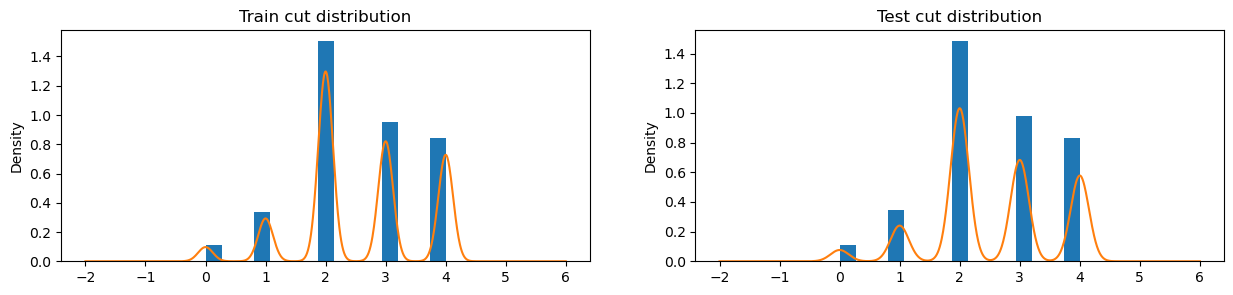

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['cut'], density=True, bins=15)
baseline_train['cut'].plot.density(ax=axes[0])
axes[0].set_title('Train cut distribution')

axes[1].hist(baseline_test['cut'], density=True, bins=15)
baseline_test['cut'].plot.density(ax=axes[1])
axes[1].set_title('Test cut distribution')

plt.show()

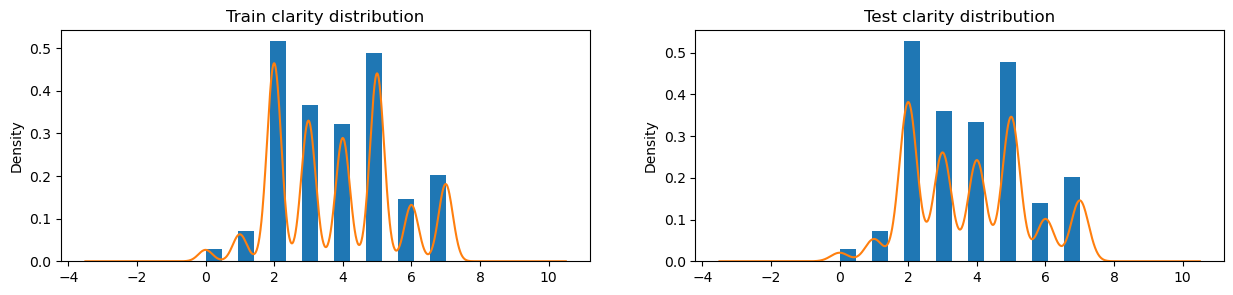

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['clarity'], density=True, bins=15)
baseline_train['clarity'].plot.density(ax=axes[0])
axes[0].set_title('Train clarity distribution')

axes[1].hist(baseline_test['clarity'], density=True, bins=15)
baseline_test['clarity'].plot.density(ax=axes[1])
axes[1].set_title('Test clarity distribution')

plt.show()

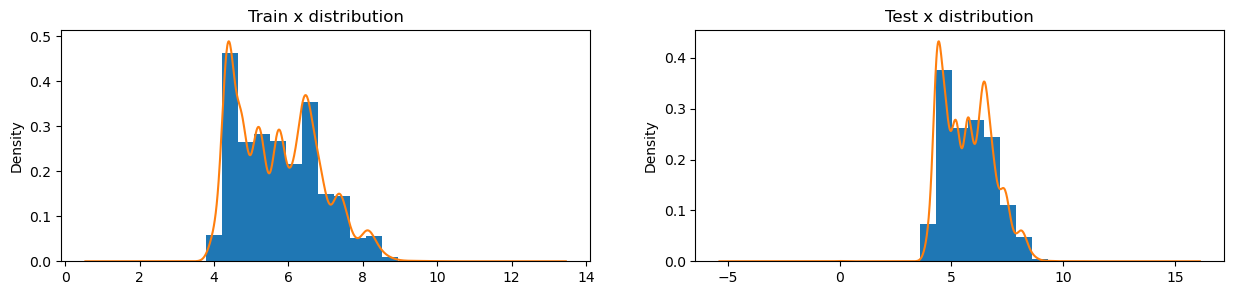

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['x'], density=True, bins=15)
baseline_train['x'].plot.density(ax=axes[0])
axes[0].set_title('Train x distribution')

axes[1].hist(baseline_test['x'], density=True, bins=15)
baseline_test['x'].plot.density(ax=axes[1])
axes[1].set_title('Test x distribution')

plt.show()

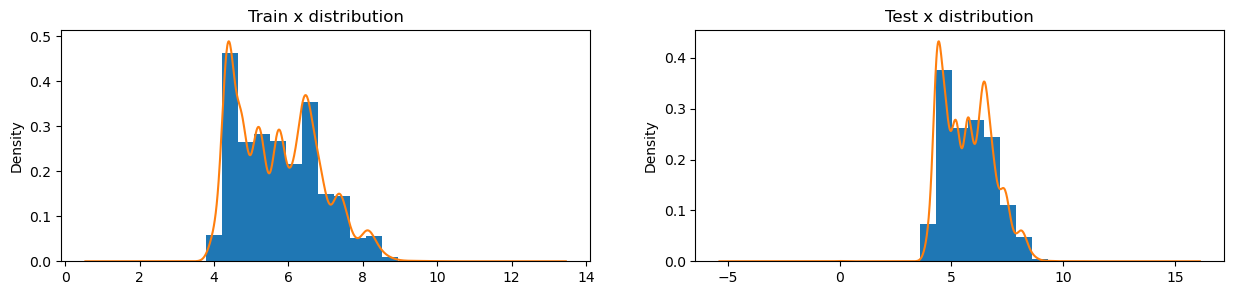

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['x'], density=True, bins=15)
baseline_train['x'].plot.density(ax=axes[0])
axes[0].set_title('Train x distribution')

axes[1].hist(baseline_test['x'], density=True, bins=15)
baseline_test['x'].plot.density(ax=axes[1])
axes[1].set_title('Test x distribution')

plt.show()

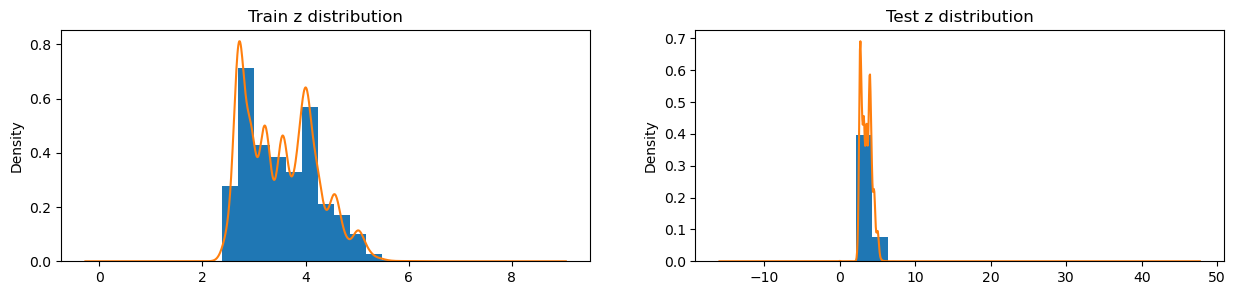

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['z'], density=True, bins=15)
baseline_train['z'].plot.density(ax=axes[0])
axes[0].set_title('Train z distribution')

axes[1].hist(baseline_test['z'], density=True, bins=15)
baseline_test['z'].plot.density(ax=axes[1])
axes[1].set_title('Test z distribution')

plt.show()

### Scalling

In [54]:
scaler = StandardScaler()
scaled_data_test = scaler.fit_transform(baseline_test)

In [55]:
scaled_data_test

array([[-0.01841187, -0.81063246,  0.66950043,  1.12187438, -1.23611732],
       [ 0.85507765,  0.98670044, -0.51495701, -0.21919161,  0.64727707],
       [ 1.64334867,  0.08803399,  0.3211306 ,  1.56889637, -0.13350489],
       ...,
       [-0.21015347,  0.98670044, -0.09691321, -1.1132356 , -1.18440443],
       [-0.21015347, -0.81063246, -2.04778429, -0.21919161, -1.17442866],
       [-0.84929214,  0.98670044,  0.46047853, -1.1132356 , -0.46207916]],
      shape=(13485, 5))

### Predict: StackingRegressor

In [56]:
model_extratrees_pred = model_extratrees.predict(scaled_data_test)

In [58]:
model_extratrees_pred

array([1066.76 , 6307.09 , 3797.905, ...,  916.52 ,  914.53 ,  899.685],
      shape=(13485,))

### Save

In [58]:
fn.save_pred(diamonds_test, model_extratrees, 'encod03_featu06_model01')

'file saved succesfully'